## Homework #1 - CSE 572 Fall '23
### Tyler Fichiera

Below is the given code from HW0 solution which is used to pre-process the data and save it as tfidf.txt

In [85]:
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuation
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # stop words
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    # stemming process
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed

def get_dict(fpath):
    dictionary = {}


    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i

    return dictionary


def get_doc_tf(word_set, dictionary):
    n_words = len(dictionary)
    tf_vec = np.zeros(n_words)

    max_cnt = 0
    for word in word_set:
        idx = dictionary[word]
        tf_vec[idx] += 1.0

        if tf_vec[idx] > max_cnt:
            max_cnt = tf_vec[idx]

    return tf_vec / max_cnt



def get_tf_idf(tf_dict, df_vec, n_doc, n_words):

    tf_idf_mtx = np.zeros((n_doc, n_words))
    idf = np.log(n_doc / df_vec)

    for doc_idx, tf_vec in tf_dict.items():
        tf_idf = tf_dict[doc_idx]*idf

        tf_idf_mtx[doc_idx, :] = tf_idf

    return tf_idf_mtx


def write(d, fpath):

    with open(fpath, "w") as f:

        for k, v in d.items():

            f.write(f"{k}\n")


def filter_top_k(counter_sorted, limit):
    top_k = {}

    for i, k in enumerate(counter_sorted.keys()):
        if i == limit:
            break
        top_k[k] = counter_sorted[k]

    return top_k

def tfidf_main(fpath, dictionary):


    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:
                continue

            doc_idx = i - 1

            id, txt, cat = line.split(",")
            cat = cat.strip()
            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)

            # get term frequency
            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec

            # get doc frequency:
            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1


    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)


    return tfidf_mtx

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tylerfichiera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerfichiera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The code below checks if tfidf.txt exists. If it does then it skips the data processing phase and loads the matrix from the file. If it does not, the data is processed using the dictionary and the tfidf_main function defined above before saving the matrix to tfidf.txt.

In [86]:
import os

matrix_file_name = "tfidf.txt"
tfidf = []
labels = []
corpus = []

if os.path.exists(matrix_file_name):
  with open("tfidf.txt", "r") as file:
    # Iterate through each line in the file
    for line in file:
        if line == "":
          break
        # Split the line by commas and convert the values to float
        row = [float(value) for value in line.strip().split(",")]
        # Append the row to the matrix
        tfidf.append(row)
else:
  tfidf = tfidf_main("news-train-1.csv", dictionary)
  np.savetxt("tfidf.txt", tfidf,  fmt='%.4f', delimiter=",")

dictionary = get_dict("dictionary.txt")
train_data = pd.read_csv("news-train-1.csv")
labels = train_data['Category']
corpus = train_data['Text']

100%|██████████| 1064/1064 [00:54<00:00, 19.49it/s]


In [87]:
tfidf

array([[0.        , 0.        , 0.36427118, ..., 0.        , 0.        ,
        0.        ],
       [0.36385541, 0.32813062, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24257027, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

2.1 - Bar chart showing the training accuracy and validation accuracy w.r.t. different parameter values.

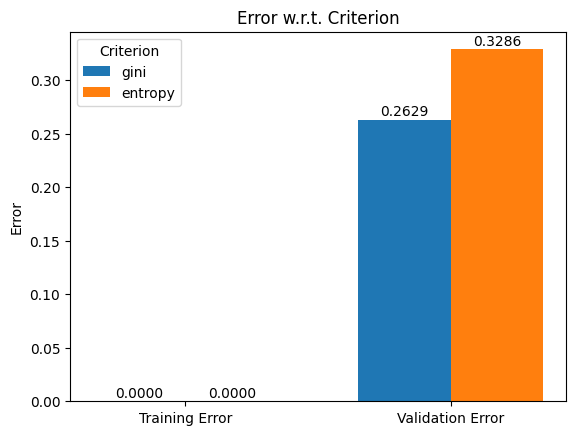

In [88]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_features = 6000)
le = LabelEncoder()

X = cv.fit_transform(corpus).toarray()
y = le.fit_transform(labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# DTM with different criterion params
criterion_values = ["gini", "entropy"]
training_errors = []
validation_errors = []

for criterion in criterion_values:
    # DTM
    model = DecisionTreeClassifier(criterion=criterion, random_state=42)
    model.fit(X_train, y_train)

    # Calculate training err
    train_error = 1 - model.score(X_train, y_train)
    training_errors.append(train_error)

    # Calculate validation err
    val_error = 1 - model.score(X_val, y_val)
    validation_errors.append(val_error)

fig, ax = plt.subplots()
index = np.arange(len(criterion_values))
bar_width = 0.35

giniBar = ax.bar(index, [training_errors[0], validation_errors[0]], bar_width, label="gini")
entropyBar = ax.bar(index + bar_width, [training_errors[1], validation_errors[1]], bar_width, label="entropy")

ax.set_ylabel("Error")
ax.set_title("Error w.r.t. Criterion")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Training Error", "Validation Error"])
ax.legend(title="Criterion")

# Annotate the bars with their values
for rect in giniBar:
    height = rect.get_height()
    ax.annotate('%.4f' % height, xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center')

for rect in entropyBar:
    height = rect.get_height()
    ax.annotate('%.4f' % height, xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center')

plt.show()

2.2 -  5-fold cross-validation w.r.t min_samples_leaf (DTC)

========= min_samples_leaf: 10
min_samples_leaf:  10
Training accuracy:  83.32352941176471 %
Validation accuracy:  68.58823529411764 %
========= min_samples_leaf: 25
min_samples_leaf:  25
Training accuracy:  73.17647058823529 %
Validation accuracy:  63.411764705882355 %
========= min_samples_leaf: 50
min_samples_leaf:  50
Training accuracy:  64.20588235294117 %
Validation accuracy:  59.1764705882353 %
========= min_samples_leaf: 75
min_samples_leaf:  75
Training accuracy:  60.58823529411765 %
Validation accuracy:  56.823529411764696 %
========= min_samples_leaf: 100
min_samples_leaf:  100
Training accuracy:  51.26470588235294 %
Validation accuracy:  45.05882352941176 %
========= min_samples_leaf: 125
min_samples_leaf:  125
Training accuracy:  49.617647058823536 %
Validation accuracy:  46.117647058823536 %
========= min_samples_leaf: 150
min_samples_leaf:  150
Training accuracy:  44.294117647058826 %
Validation accuracy:  40.470588235294116 %


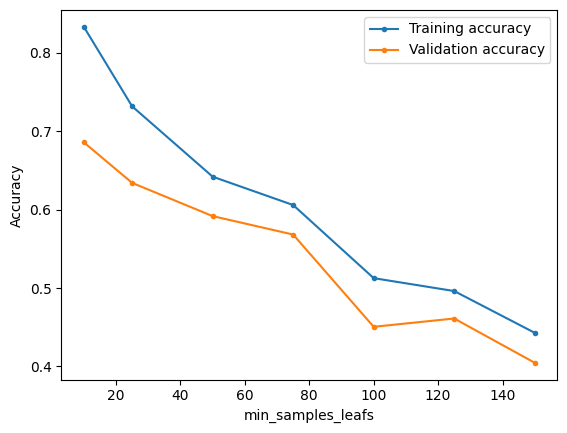

[0.8332352941176471, 0.7317647058823529, 0.6420588235294117, 0.6058823529411765, 0.5126470588235295, 0.49617647058823533, 0.4429411764705883]
[0.6858823529411764, 0.6341176470588236, 0.591764705882353, 0.568235294117647, 0.4505882352941176, 0.46117647058823535, 0.40470588235294114]


In [89]:
from sklearn.model_selection import KFold

def dtc_wrt_min_samples_leaf(train_val_X, train_val_y):
    min_samples_leafs = [10, 25, 50, 75, 100, 125, 150]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for leaf in min_samples_leafs:
        train_acc = []
        val_acc = []
        print("========= min_samples_leaf:", leaf)
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = DecisionTreeClassifier(min_samples_leaf=leaf)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("min_samples_leaf: ", leaf)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return min_samples_leafs, train_acc_all, val_acc_all

min_samples_leafs, train_acc_all, val_acc_all = dtc_wrt_min_samples_leaf(X_train, y_train)

# plot training/validation curves
plt.plot(min_samples_leafs, train_acc_all, marker='.', label="Training accuracy")
plt.plot(min_samples_leafs, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('min_samples_leafs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(train_acc_all)
print(val_acc_all)

2.3 - 5-fold cross-validation w.r.t max_features (DTC)

========= max_features: 10
max_features:  10
Training accuracy:  100.0 %
Validation accuracy:  55.17647058823529 %
========= max_features: 25
max_features:  25
Training accuracy:  100.0 %
Validation accuracy:  56.94117647058825 %
========= max_features: 50
max_features:  50
Training accuracy:  100.0 %
Validation accuracy:  61.17647058823529 %
========= max_features: 75
max_features:  75
Training accuracy:  100.0 %
Validation accuracy:  58.705882352941174 %
========= max_features: 100
max_features:  100
Training accuracy:  100.0 %
Validation accuracy:  64.58823529411765 %
========= max_features: 125
max_features:  125
Training accuracy:  100.0 %
Validation accuracy:  67.05882352941177 %
========= max_features: 150
max_features:  150
Training accuracy:  100.0 %
Validation accuracy:  65.41176470588235 %


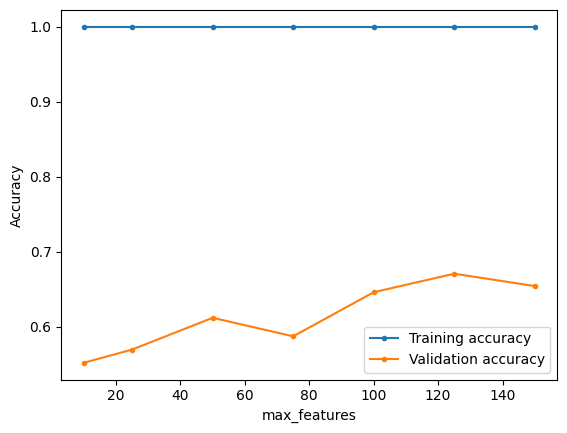

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.5517647058823529, 0.5694117647058825, 0.6117647058823529, 0.5870588235294117, 0.6458823529411765, 0.6705882352941177, 0.6541176470588235]


In [90]:
def dtc_wrt_max_features(train_val_X, train_val_y):
    max_features = [10, 25, 50, 75, 100, 125, 150]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    for feature in max_features:
        train_acc = []
        val_acc = []
        print("========= max_features:", feature)
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = DecisionTreeClassifier(max_features=feature)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("max_features: ", feature)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return max_features, train_acc_all, val_acc_all

max_features, train_acc_all, val_acc_all = dtc_wrt_max_features(X_train, y_train)

# plot training/validation curves
plt.plot(max_features, train_acc_all, marker='.', label="Training accuracy")
plt.plot(max_features, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(train_acc_all)
print(val_acc_all)

3.2 -  5-fold cross-validation w.r.t n_estimators (RFM)

========= n_estimators: 10
n_estimators:  10
Training accuracy:  99.88235294117646 %
Validation accuracy:  85.05882352941177 %
========= n_estimators: 25
n_estimators:  25
Training accuracy:  100.0 %
Validation accuracy:  91.29411764705881 %
========= n_estimators: 50
n_estimators:  50
Training accuracy:  100.0 %
Validation accuracy:  94.0 %
========= n_estimators: 75
n_estimators:  75
Training accuracy:  100.0 %
Validation accuracy:  93.88235294117648 %
========= n_estimators: 100
n_estimators:  100
Training accuracy:  100.0 %
Validation accuracy:  95.17647058823529 %
========= n_estimators: 125
n_estimators:  125
Training accuracy:  100.0 %
Validation accuracy:  94.58823529411765 %
========= n_estimators: 150
n_estimators:  150
Training accuracy:  100.0 %
Validation accuracy:  94.94117647058825 %


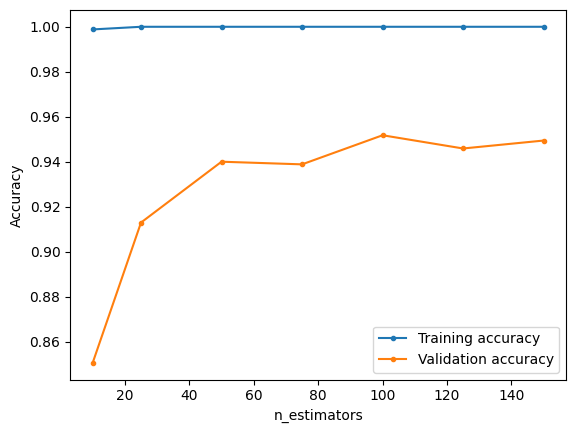

[0.9988235294117647, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.8505882352941176, 0.9129411764705881, 0.9400000000000001, 0.9388235294117647, 0.951764705882353, 0.9458823529411765, 0.9494117647058824]


In [91]:
from sklearn.ensemble import RandomForestClassifier

def rfc_wrt_n_estimators(train_val_X, train_val_y):
    n_estimators = [10, 25, 50, 75, 100, 125, 150]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits=5)
    for n_estimator in n_estimators:
        train_acc = []
        val_acc = []
        print("========= n_estimators:", n_estimator)
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X[train_index, :]
            val_X = train_val_X[val_index, :]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]

            # Create a Random Forest Classifier with the current n_estimators value
            rf = RandomForestClassifier(n_estimators=n_estimator)
            rf.fit(train_X, train_y)
            train_acc.append(rf.score(train_X, train_y))
            val_acc.append(rf.score(val_X, val_y))
            # print("========= val_index:", val_index)

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("n_estimators: ", n_estimator)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return n_estimators, train_acc_all, val_acc_all

n_estimators, train_acc_all, val_acc_all = rfc_wrt_n_estimators(X_train, y_train)

# Plot training/validation curves
plt.plot(n_estimators, train_acc_all, marker='.', label="Training accuracy")
plt.plot(n_estimators, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(train_acc_all)
print(val_acc_all)

3.3 -  5-fold cross-validation w.r.t min_samples_leaf (RFM)

========= min_samples_leaf: 1
min_samples_leaf:  1
Training accuracy:  100.0 %
Validation accuracy:  94.23529411764706 %
========= min_samples_leaf: 2
min_samples_leaf:  2
Training accuracy:  100.0 %
Validation accuracy:  94.82352941176471 %
========= min_samples_leaf: 4
min_samples_leaf:  4
Training accuracy:  99.58823529411764 %
Validation accuracy:  94.58823529411765 %
========= min_samples_leaf: 8
min_samples_leaf:  8
Training accuracy:  98.38235294117646 %
Validation accuracy:  93.17647058823528 %
========= min_samples_leaf: 16
min_samples_leaf:  16
Training accuracy:  95.55882352941177 %
Validation accuracy:  89.76470588235294 %
========= min_samples_leaf: 32
min_samples_leaf:  32
Training accuracy:  85.6764705882353 %
Validation accuracy:  80.11764705882352 %
========= min_samples_leaf: 64
min_samples_leaf:  64
Training accuracy:  56.70588235294118 %
Validation accuracy:  50.35294117647059 %


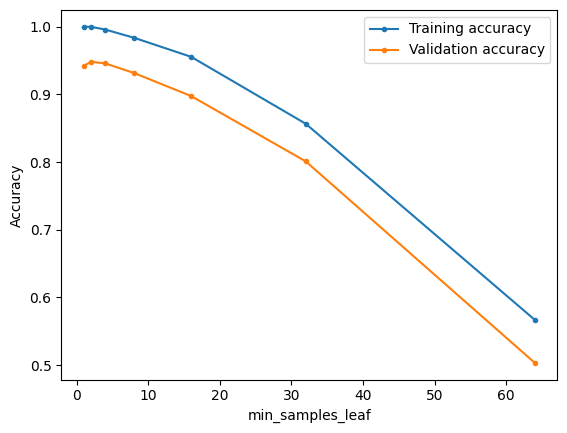

[1.0, 1.0, 0.9958823529411764, 0.9838235294117647, 0.9555882352941177, 0.856764705882353, 0.5670588235294118]
[0.9423529411764706, 0.9482352941176471, 0.9458823529411765, 0.9317647058823528, 0.8976470588235295, 0.8011764705882353, 0.5035294117647059]


In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def rfc_wrt_min_samles_leaf(train_val_X, train_val_y):
    min_samples_leaf_values = [1, 2, 4, 8, 16, 32, 64]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits=5)
    for min_samples_leaf in min_samples_leaf_values:
        train_acc = []
        val_acc = []
        print("========= min_samples_leaf:", min_samples_leaf)
        for train_index, val_index in kf.split(train_val_X):
            train_X = train_val_X[train_index, :]
            val_X = train_val_X[val_index, :]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]

            # Create a Random Forest Classifier with the current min_samples_leaf value
            rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
            rf.fit(train_X, train_y)
            train_acc.append(rf.score(train_X, train_y))
            val_acc.append(rf.score(val_X, val_y))
            # print("========= val_index:", val_index)

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        print("min_samples_leaf: ", min_samples_leaf)
        print("Training accuracy: ", avg_train_acc * 100, "%")
        print("Validation accuracy: ", avg_val_acc * 100, "%")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)

    return min_samples_leaf_values, train_acc_all, val_acc_all

min_samples_leaf_values, train_acc_all, val_acc_all = rfc_wrt_min_samles_leaf(X_train, y_train)

# Plot training/validation curves
plt.plot(min_samples_leaf_values, train_acc_all, marker='.', label="Training accuracy")
plt.plot(min_samples_leaf_values, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print(train_acc_all)
print(val_acc_all)

4 - predict the labels for testing data and save to a csv called labels.csv using DecisionTreeClassifier.

In [93]:
model = DecisionTreeClassifier(criterion='gini', random_state=42, min_samples_leaf=10)
model.fit(X_train, y_train)
test_data = pd.read_csv("news-test.csv")
corpus_test = []

for i, row in test_data.iterrows():
    text = row['Text']
    tokens = get_tokens(text)
    filtered = []
    filtered_unique = set()
    for word in tokens:
        if word in dictionary:
            filtered.append(word)
            filtered_unique.add(word)
    corpus_test.append(' '.join(filtered))

X_test = cv.transform(corpus_test).toarray()

predictions = model.predict(X_test)

with open("labels.csv", "w") as label_file:
    for i, row in test_data.iterrows():
        articleId = row['ArticleId']
        category = le.inverse_transform([predictions[i]])[0]
        label_file.write(f"{articleId},{category}\n")